In [13]:
import os
import pandas as pd
from glob import glob
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from trustee import ClassificationTrustee
from trustee.report.trust import TrustReport

In [2]:
# Base path where all method folders are
METHOD = "mpc"
base_path = f'./ABR_Separated/{METHOD}/'

# Collect all merged CSVs
all_dfs = []

print("Loading CSV files...")

# Loop through each ABR method folder
path_pattern = os.path.join(base_path, '*.csv')  # Match all CSVs under each method folder
for file_path in glob(path_pattern):
    try:
        df = pd.read_csv(file_path, dtype=str)
        all_dfs.append(df)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")

Loading CSV files...


In [3]:
# Combine all data
print("Combining CSVs into one DataFrame...")
data = pd.concat(all_dfs, ignore_index=True)
print(f"Total rows loaded: {len(data)}")

Combining CSVs into one DataFrame...
Total rows loaded: 124482


In [4]:
# Drop columns
non_mpc_columns = [
    'time (ns GMT)', 'session_id', 'video_ts_x', 'ssim_index_x',
    'index_y', 'expt_id_y', 'channel_y', 'source_dataset_y', "index_x", "expt_id_x",
    "channel_x", "event_y", "buffer_y", "cum_rebuf_y", "source_dataset_x", 
    'index_y.1', 'expt_id_y.1', 'channel_y.1', 'video_ts_y', 'format_y',
    'size_y', 'ssim_index_y', 'cwnd_y', 'in_flight_y', 'min_rtt_y', 'rtt_y',
    'delivery_rate_y', 'source_dataset_y.1'
]

data = data.drop(columns=non_mpc_columns)
print(data.columns)

Index(['format_x', 'size_x', 'cwnd_x', 'in_flight_x', 'min_rtt_x', 'rtt_x',
       'delivery_rate_x', 'event_x', 'buffer_x', 'cum_rebuf_x'],
      dtype='object')


In [5]:
# Rename format_x to PlaybackQuality
data["PlaybackQuality"] = data["format_x"]
data.drop(columns=['format_x'], inplace=True)

In [6]:
# Encode event_x labels as integers
event_labels = data["event_x"].unique()
event_to_index = {q: i for i, q in enumerate(event_labels)}
data['event_x'] = data['event_x'].map(event_to_index)

In [7]:
# Convert columns to numeric"
for col in tqdm(data.columns, desc="Converting columns to numeric"):
    if col == 'PlaybackQuality':
        continue
    data[col] = pd.to_numeric(data[col], errors='ignore')

print(data.head())

Converting columns to numeric: 100%|████████████| 10/10 [00:00<00:00, 45.92it/s]


In [9]:
# Encode labels
le = LabelEncoder()
data['PlaybackQuality'] = le.fit_transform(data['PlaybackQuality'])

# Separate features and labels
X = data.drop(columns=['PlaybackQuality'])
y = data['PlaybackQuality']

In [10]:
# Split
print("Splitting into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train
print("Training Random Forest Classifier...")
clf = RandomForestClassifier(n_estimators=10, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
print("Evaluating model...")
y_pred = clf.predict(X_test)

Splitting into training and test sets...
Training Random Forest Classifier...
Evaluating model...


findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were foun

Classification Report:
              precision    recall  f1-score   support

 1280x720-20       0.85      0.91      0.88      7818
 1280x720-22       0.28      0.17      0.21      1012
 1280x720-24       0.27      0.20      0.23       546
 1280x720-26       0.27      0.21      0.23       379
1920x1080-22       0.89      0.96      0.92     12469
1920x1080-24       0.28      0.08      0.13      1049
  426x240-26       0.81      0.94      0.87       852
  640x360-24       0.29      0.18      0.22       148
  640x360-26       0.41      0.26      0.32        82
  854x480-22       0.23      0.14      0.17       101
  854x480-24       0.19      0.12      0.15       240
  854x480-26       0.25      0.12      0.17       201

    accuracy                           0.82     24897
   macro avg       0.42      0.36      0.37     24897
weighted avg       0.78      0.82      0.80     24897



findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were foun

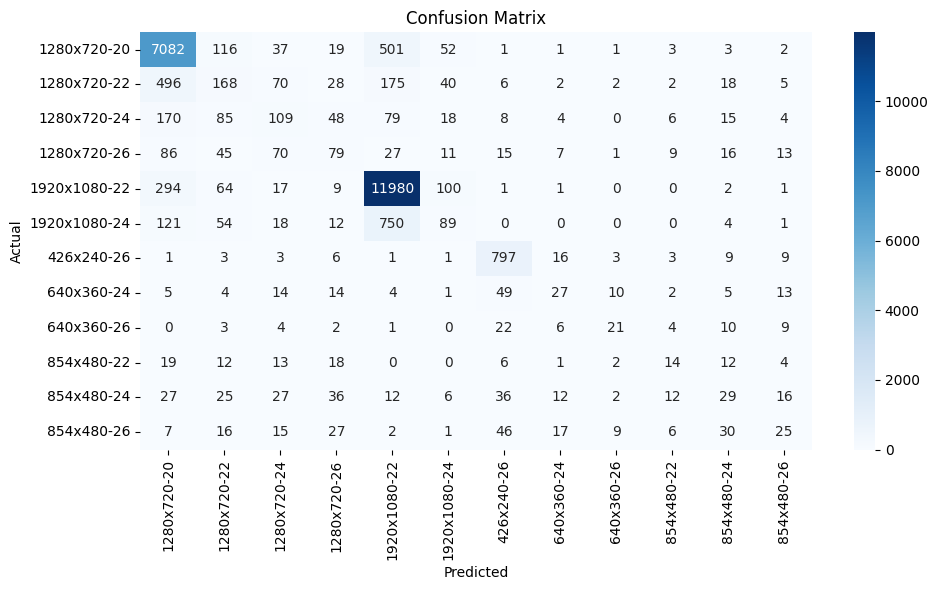

In [11]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [12]:
importances = clf.feature_importances_
feat_names = X.columns

for name, imp in sorted(zip(feat_names, importances), key=lambda x: -x[1])[:20]:
    print(f"{name}: {imp:.4f}")

cum_rebuf_x: 0.2223
min_rtt_x: 0.1887
size_x: 0.1552
rtt_x: 0.1264
buffer_x: 0.1072
cwnd_x: 0.0939
delivery_rate_x: 0.0939
in_flight_x: 0.0104
event_x: 0.0020


In [14]:
trustee = ClassificationTrustee(expert=clf)
trustee.fit(X_train, y_train, num_iter=50, num_stability_iter=10, samples_size=0.3, verbose=True)
dt, pruned_dt, agreement, reward = trustee.explain()
dt_y_pred = dt.predict(X_test)

print("Fidelity to original model:")
print(classification_report(y_pred, dt_y_pred))

print("Accuracy vs. true labels:")
print(classification_report(y_test, dt_y_pred))

Initializing training dataset using RandomForestClassifier(n_estimators=10, random_state=42) as expert model
Expert model score: 0.9792604855704846
Initializing Trustee outer-loop with 10 iterations
########## Outer-loop Iteration 0/10 ##########
Initializing Trustee inner-loop with 10 iterations
########## Inner-loop Iteration 0/50 ##########
Sampling 20912 points from training dataset with (69709, 69709) entries
Student model 0-0 trained with depth 33 and 2606 leaves:
Student model score: 0.30699449273915347
Student model 0-0 fidelity: 0.30699449273915347
########## Inner-loop Iteration 1/50 ##########
Sampling 20912 points from training dataset with (75983, 75983) entries
Student model 0-1 trained with depth 31 and 2548 leaves:
Student model score: 0.3432086289391214
Student model 0-1 fidelity: 0.3432086289391214
########## Inner-loop Iteration 2/50 ##########
Sampling 20912 points from training dataset with (82257, 82257) entries
Student model 0-2 trained with depth 37 and 2507 lea

/Users/Bryce/anaconda3/envs/trustee/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [ ]:
OUTPUT_PATH = "out"
REPORT_PATH = f"{OUTPUT_PATH}/report/trust_report.obj"

if os.path.exists(REPORT_PATH):
    print(f"Loading trust report from {REPORT_PATH}...")
    trust_report = TrustReport.load(REPORT_PATH)
    print("Done!")
else:
    trust_report = TrustReport(
        blackbox=clf,
        X=X,
        y=y,
        X_train=X_train,
        X_test=X_test,
        y_train=y_train,
        y_test=y_test,
        max_iter=5,
        num_pruning_iter=5,
        train_size=0.7,
        trustee_num_iter=10,
        trustee_num_stability_iter=5,
        trustee_sample_size=0.3,
        analyze_branches=True,
        analyze_stability=True,
        top_k=10,
        verbose=True,
        class_names=list(le.classes_),
        feature_names=list(X.columns),
        is_classify=True,
    )

print(trust_report)
trust_report.save(OUTPUT_PATH)

Running Trust Report...
Preparing data...
Done!
Progress |----------------------------------------------------------------------------------------------------| 0.8% Complete
Done!
Progress |█---------------------------------------------------------------------------------------------------| 1.6% Complete
Fitting blackbox model...
Done!
Blackbox model score report with training data:

              precision    recall  f1-score   support

           0      0.852     0.906     0.878      7818
           1      0.282     0.166     0.209      1012
           2      0.275     0.200     0.231       546
           3      0.265     0.208     0.233       379
           4      0.885     0.961     0.922     12469
           5      0.279     0.085     0.130      1049
           6      0.807     0.935     0.867       852
           7      0.287     0.182     0.223       148
           8      0.412     0.256     0.316        82
           9      0.230     0.139     0.173       101
          10      